---

## Project Overview
This project aims to develop a deep learning model capable of classifying chest X-ray images into two categories: 'NORMAL' and 'PNEUMONIA'. The model is built upon the ResNet50 architecture, a popular deep residual network known for its performance on image classification tasks. We further fine-tune this pre-trained model to suit our specific binary classification problem.

## Use Cases
The model developed in this project can be used in medical facilities, especially in areas with limited access to radiologists, to assist in the preliminary diagnosis of pneumonia. By providing immediate feedback, healthcare workers can make timely decisions about patient care. However, it's crucial to understand that while the model can aid diagnosis, a medical professional should always validate its predictions.

## Interpretation of Visualizations
- **Training and Validation Curves**: These curves provide insights into the model's learning process. If both curves follow each other closely, it indicates a good fit. A large gap may suggest overfitting.
  
- **Test Predictions**: Visual representations of the model's predictions on individual test samples. Green labels are correct predictions, while red labels indicate errors.
  
- **Grad-CAM**: Gradient-weighted Class Activation Mapping (Grad-CAM) uses the gradients of any target concept flowing into the final convolutional layer to produce a heatmap visualization. This helps in understanding which parts of the image influenced the model's decision.

- **Confusion Matrix**: This matrix provides a breakdown of the model's predictions, highlighting true positives, true negatives, false positives, and false negatives. It's a comprehensive representation of the model's performance across both classes.
  
- **ROC Curve**: The Receiver Operating Characteristic (ROC) curve plots the true positive rate against the false positive rate at various threshold settings. The Area Under the Curve (AUC) provides a scalar value of the model's overall performance.

---


## Data Processing and Verifying

In [1]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Directly specify the directories relative to the notebook's location
train_dir = 'Data/train'
val_dir = 'Data/val'
test_dir = 'Data/test'

# Parameters
TARGET_SIZE = (224, 224)  # Standard size for VGG, ResNet
BATCH_SIZE = 32

# Data Augmentation for Training Data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
)

# Only rescaling for Validation and Test Data
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Load images from directories and apply augmentations
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [2]:
print(f"Total training samples: {train_generator.samples}")


Total training samples: 5216


In [3]:
print(f"Batch size: {BATCH_SIZE}")


Batch size: 32


In [4]:
steps_per_epoch_value = train_generator.samples // BATCH_SIZE
print(f"Steps per epoch: {steps_per_epoch_value}")


Steps per epoch: 163


## Model Training

In [5]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout

# Initialize the pre-trained model
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Freeze the layers of the base model (we won't train these)
for layer in base_model.layers:
    layer.trainable = False

# Create a new sequential model
model = Sequential()

# Add the base model
model.add(base_model)

# Flatten the output to connect with dense layers
model.add(Flatten())

# Add a dense layer
model.add(Dense(256, activation='relu'))

# Add a dropout layer for regularization (optional but can help prevent overfitting)
model.add(Dropout(0.5))

# Final binary classification layer (NORMAL vs PNEUMONIA)
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model architecture
model.summary()

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_steps=1
)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 256)               25690368  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 49278337 (187.98 MB)
Trainable params: 25690625 (98.00 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________
Epoch 1

## Training and Validation Curves:


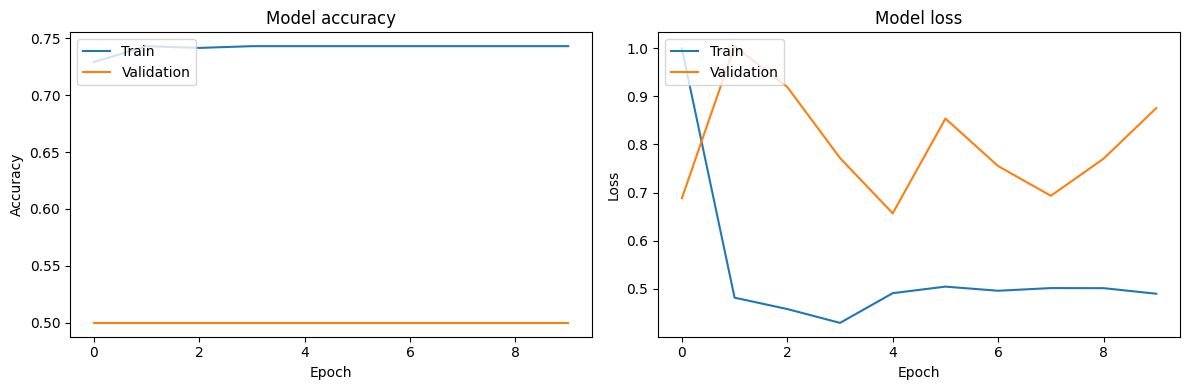

In [6]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


## Test Cases and Predictions:

1/1 [==============================] - 3s 3s/step


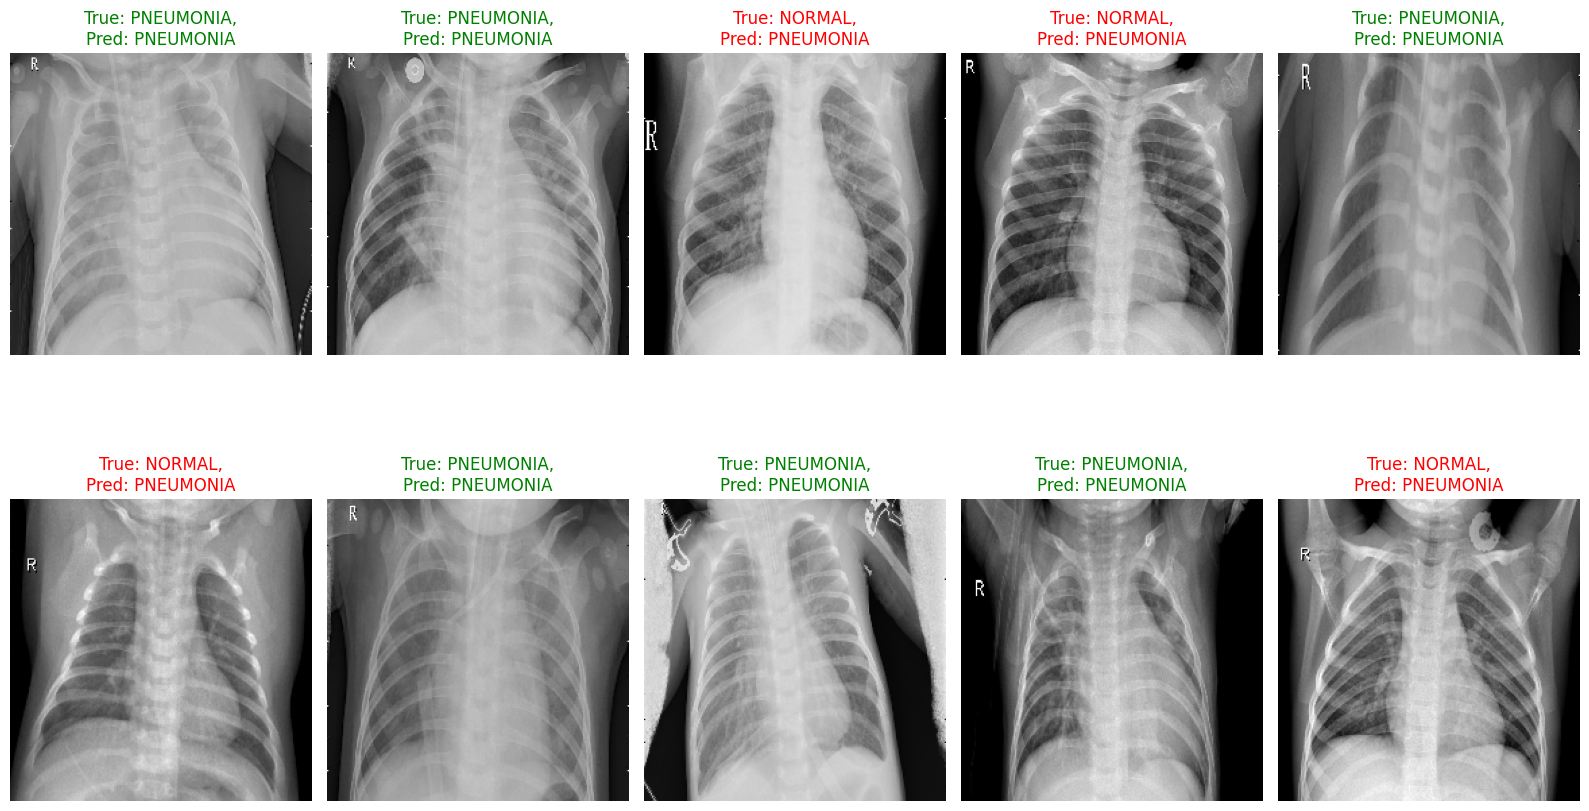

In [7]:
import numpy as np

# Get a batch of data from the test generator
test_images, test_labels = next(test_generator)

# Predict using the model
predictions = model.predict(test_images)

# Plot the images, true labels, and predictions
plt.figure(figsize=(16, 10))
for i in range(10):  # Displaying the first 10 images
    plt.subplot(2, 5, i+1)
    plt.imshow(test_images[i])
    color = "green" if np.round(predictions[i]) == test_labels[i] else "red"
    plt.title(f"True: {'PNEUMONIA' if test_labels[i] else 'NORMAL'},\nPred: {'PNEUMONIA' if np.round(predictions[i]) else 'NORMAL'}", color=color)
    plt.axis('off')

plt.tight_layout()
plt.show()


## Grad-CAM for Model Interpretation:

In [8]:
base_model_name = 'resnet50'
nested_model = model.get_layer(base_model_name)
for layer in nested_model.layers:
    print(layer.name)


input_1
conv1_pad
conv1_conv
conv1_bn
conv1_relu
pool1_pad
pool1_pool
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_conv
conv2_block1_2_bn
conv2_block1_2_relu
conv2_block1_0_conv
conv2_block1_3_conv
conv2_block1_0_bn
conv2_block1_3_bn
conv2_block1_add
conv2_block1_out
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_conv
conv2_block2_2_bn
conv2_block2_2_relu
conv2_block2_3_conv
conv2_block2_3_bn
conv2_block2_add
conv2_block2_out
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_conv
conv2_block3_2_bn
conv2_block3_2_relu
conv2_block3_3_conv
conv2_block3_3_bn
conv2_block3_add
conv2_block3_out
conv3_block1_1_conv
conv3_block1_1_bn
conv3_block1_1_relu
conv3_block1_2_conv
conv3_block1_2_bn
conv3_block1_2_relu
conv3_block1_0_conv
conv3_block1_3_conv
conv3_block1_0_bn
conv3_block1_3_bn
conv3_block1_add
conv3_block1_out
conv3_block2_1_conv
conv3_block2_1_bn
conv3_block2_1_relu
conv3_block2_2_conv
conv3_block2_2_bn
conv3_

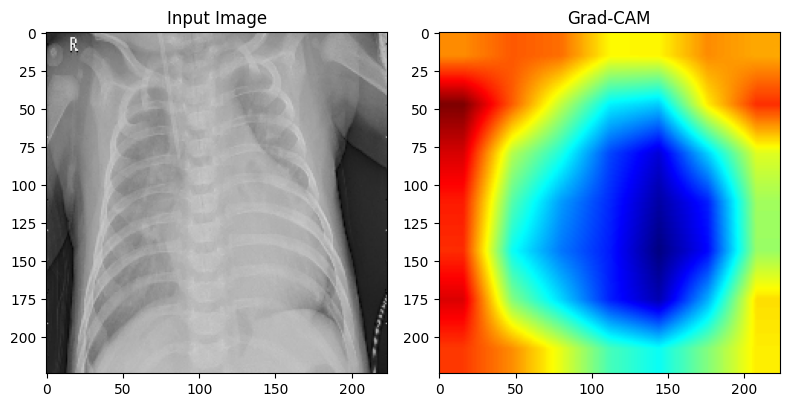

In [9]:
!pip install opencv-python

from tensorflow.keras.models import Model

import cv2

def grad_cam(model, image, base_model_name, layer_name):
    # Get the nested ResNet50 model
    nested_model = model.get_layer(base_model_name)
    
    # Extract the output of the desired layer from the nested model
    target_layer_output = nested_model.get_layer(layer_name).output
    
    # Create the grad_model using the input tensor of the primary model and the desired output tensors
    grad_model = Model(inputs=nested_model.input, outputs=[target_layer_output, nested_model.output])
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(np.array([image]))
        loss = predictions[:, 0]

    output = conv_outputs[0]
    grads = tape.gradient(loss, conv_outputs)[0]

    gate_f = tf.cast(output > 0, 'float32')
    gate_r = tf.cast(grads > 0, 'float32')
    guided_grads = gate_f * gate_r * grads

    weights = tf.reduce_mean(guided_grads, axis=(0, 1))
    cam = np.ones(output.shape[0: 2], dtype=np.float32)

    for i, w in enumerate(weights):
        cam += w * output[:, :, i]

    cam = cv2.resize(cam.numpy(), (224, 224))
    cam = np.maximum(cam, 0)
    heatmap = (cam - cam.min()) / (cam.max() - cam.min())

    cam = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    cam = np.float32(cam) + np.float32(image)
    cam = 255 * cam / np.max(cam)
    
    return np.uint8(cam), heatmap

# Choose an image from test set
img = test_images[0]

# Get Grad-CAM image and heatmap
cam_image, heatmap = grad_cam(model, img, 'resnet50', 'conv5_block3_out')

# Display results
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Input Image")
plt.subplot(1, 2, 2)
plt.imshow(cam_image)
plt.title("Grad-CAM")
plt.tight_layout()
plt.show()


20/20 [==============================] - 52s 2s/step


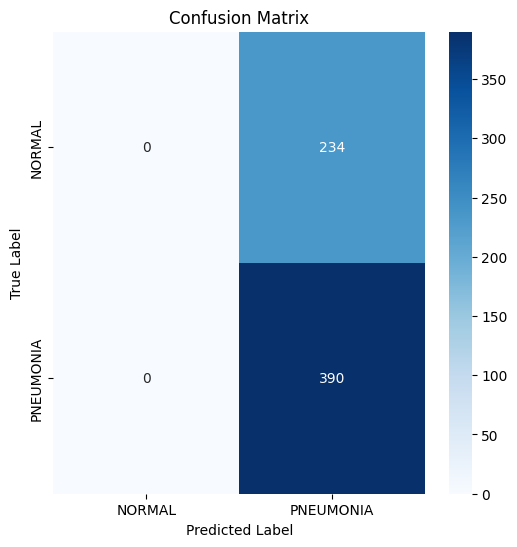

In [10]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, generator, class_names):
    # Get the true labels and predictions
    true_labels = generator.labels
    predictions = model.predict(generator)
    pred_labels = np.round(predictions).flatten()
    
    # Compute the confusion matrix
    cm = confusion_matrix(true_labels, pred_labels)
    
    # Plot the confusion matrix
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# Usage:
plot_confusion_matrix(model, test_generator, ['NORMAL', 'PNEUMONIA'])


In [11]:
!pip install pydot graphviz
from tensorflow.keras.utils import plot_model

# Plot and save the model architecture
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


20/20 [==============================] - 38s 2s/step


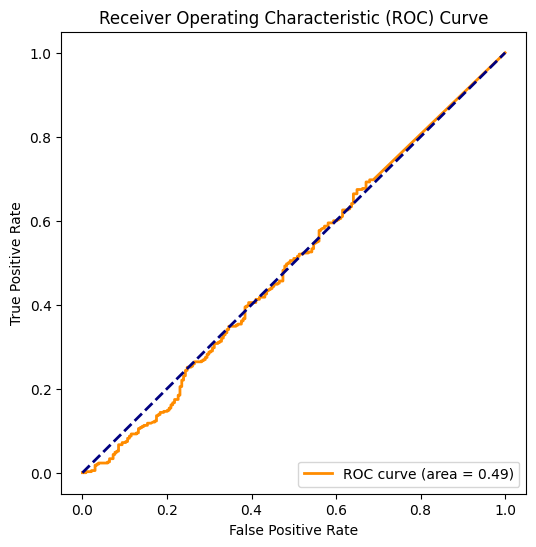

In [12]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(model, generator):
    true_labels = generator.labels
    predictions = model.predict(generator).flatten()
    
    fpr, tpr, _ = roc_curve(true_labels, predictions)
    auc_value = auc(fpr, tpr)
    
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc_value:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

# Usage:
plot_roc_curve(model, test_generator)


### Potential Improvements
1. **Data Augmentation**: Expanding the dataset by introducing various augmentations can enhance the model's generalization capabilities.
  
2. **Model Ensembling**: Combining predictions from multiple models can lead to improved accuracy.
  
3. **Transfer Learning with Different Architectures**: Trying different base architectures like VGG16, Inception, etc., might yield better results.
  
4. **Fine-tuning and Hyperparameter Optimization**: Using tools like Keras Tuner or Optuna to search for the best hyperparameters can boost performance.
  
5. **Feedback Loop**: Implementing a system where radiologists can correct or validate the model's predictions can help in continually refining the model.

6. **Extend to Multi-Class Classification**: If data is available, the model can be extended to classify various types of X-rays, not just chest X-rays.